I'm gonna overwrite a lot of this notebook's old content. I changed the way I'm calculating wt, and wanna test that my training worked. 

In [21]:
from pearce.emulator import OriginalRecipe, ExtraCrispy
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [22]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [23]:
training_dir = '/u/ki/swmclau2/des/PearceLHC_wt_z/'

em_method = 'gp'
split_method = 'random'

In [24]:
%%bash
ls -d ~/des/PearceLHC_wt_z/*

/u/ki/swmclau2/des/PearceLHC_wt_z/a_0.81120


In [25]:
a = 0.81120
z = 1.0/a - 1.0


In [26]:
fixed_params = {'z':z}#, 'r':0.18477483}

In [27]:
emu = OriginalRecipe(training_dir, method = em_method, fixed_params=fixed_params, independent_variable=None)

In [28]:
emu._ordered_params

OrderedDict([('logMmin', (13.0, 14.5)),
             ('sigma_logM', (0.05, 1.0)),
             ('logM0', (10, 13)),
             ('logM1', (13.0, 16.0)),
             ('alpha', (0.7, 1.2)),
             ('f_c', (0.05, 0.5)),
             ('mean_occupation_satellites_assembias_param1', (-1.0, 1.0)),
             ('mean_occupation_centrals_assembias_param1', (-1.0, 1.0)),
             ('r', (0.047060950000000004, 3.7381838250000001))])

In [29]:
print emu.y

[ 3.56310393  1.5153413   0.31860275 ..., -0.56532767 -0.56649129
 -0.56780204]


In [30]:
emu.x[0,:-1]

array([ 14.055,   0.082,  12.032,  15.411,   0.755,   0.394,  -0.9  ,
        -0.186])

In [31]:
emu._ordered_params.keys()

['logMmin',
 'sigma_logM',
 'logM0',
 'logM1',
 'alpha',
 'f_c',
 'mean_occupation_satellites_assembias_param1',
 'mean_occupation_centrals_assembias_param1',
 'r']

In [32]:
l = len(emu.scale_bin_centers)
idx = 0
params = {pname:pval for pname, pval in zip(emu._ordered_params.iterkeys(), emu.x[idx*l,:-1])}

In [33]:
for k,v in params.iteritems():
    print k,'\t'*5,v

logMmin 					14.055
mean_occupation_centrals_assembias_param1 					-0.186
f_c 					0.394
logM0 					12.032
sigma_logM 					0.082
mean_occupation_satellites_assembias_param1 					-0.9
logM1 					15.411
alpha 					0.755


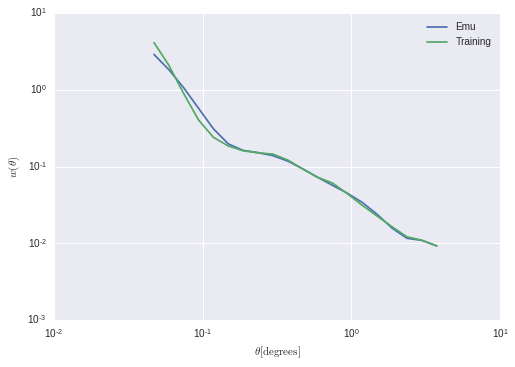

In [34]:
wt = emu.emulate_wrt_r(params, emu.scale_bin_centers)[0]
plt.plot(emu.scale_bin_centers, wt, label = 'Emu')
l = len(emu.scale_bin_centers)
plt.plot(emu.scale_bin_centers, emu.y[(idx)*l:(idx+1)*l]+emu.y_hat, label = 'Training')
plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta \mathrm{[degrees]}$')
plt.loglog();
plt.xscale('log')
plt.legend(loc='best')

In [16]:
print wt

[ 2.04149518  1.37231511  0.88222488  0.56031816  0.3721896   0.27413158
  0.22564682  0.1973651   0.17326104  0.14805196  0.12221866  0.09751422
  0.07480874  0.05426049  0.03635647  0.02228023  0.01317098  0.00898534
  0.00779457  0.00548626]


In [17]:
from pearce.mocks import compute_prim_haloprop_bins, cat_dict

In [18]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[a]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(a)
#halo_masses = cat.halocat.halo_table['halo_mvir']

In [19]:
cat.load_model(a, 'hsabRedMagic')

In [20]:
binno = 1
params = {pname:val for pname, val in zip(emu._ordered_params.iterkeys(), emu.x[binno*binlen,:-1])}
cat.populate(params)

NameError: name 'binlen' is not defined

wt = cat.calc_wt(theta_bins, do_jackknife=False,n_cores=1)

In [ ]:
theta_bins = np.logspace(np.log10(2.5), np.log10(250), 20)/60
tpoints = (theta_bins[1:]+theta_bins[:-1])/2

In [ ]:
fig = plt.figure(figsize=(45,14))


emulation_point = [('f_c', 0.233), ('logM0', 12.0), ('sigma_logM', 0.333),
                    ('alpha', 1.053),('logM1', 13.5), ('logMmin', 12.033)]

em_params = dict(emulation_point)

em_params.update(fixed_params)
del em_params['z']

fixed_params2 = {'mean_occupation_satellites_assembias_param1':0.0,
                'mean_occupation_centrals_assembias_param1':0.0,
                'disp_func_slope_satellites':1.0,
                'disp_func_slope_centrals':1.0}

for idx, (param, bounds) in enumerate(emu._ordered_params.iteritems()):
    if param == 'r':
        continue
    wt_vals = []
    new_em_params = {}
    new_em_params.update(em_params)
    new_em_params.update(fixed_params2)
    for v in np.linspace(bounds[0], bounds[1], 6):
        new_em_params[param] = v
        wt_vals.append(emu.emulate_wrt_r(new_em_params, tpoints))
    wt_vals = np.array(wt_vals)
    
    pal = sns.cubehelix_palette(wt_vals.shape[0], start=idx, rot=0.3,\
                            dark=0.0, light=.60,reverse = True)
    #sns.palplot(pal)

    sns.set_palette(pal)

    #sns.set_style("darkgrid", {"axes.facecolor": "0.85"})
    plt.subplot(5,2,idx+1)

    for color, wt, v in zip(pal, wt_vals,np.linspace(bounds[0], bounds[1], 6) ):
        plt.plot(tpoints, 1+wt[0,:], color = color, label = r'%s = %.1f'%(param,v) )
    #plt.loglog()
    plt.xscale('log')
    plt.legend(loc='best')
    plt.xlim([0.1, 4])
    plt.title(r'$w(\theta)$ variance by %s'%param)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$w(\theta)$')
plt.show()